In [5]:
!git clone https://github.com/CMU-MultiComp-Lab/CMU-MultimodalSDK.git
!cp -r CMU-MultimodalSDK/mmsdk mmsdk

In [9]:
!pip install transformers -q
!pip install validators -q
!pip install colorama -q

In [29]:
import random
import torch

import pandas as pd
import numpy as np
import torch.nn as nn

from typing import NamedTuple
from tqdm import tqdm
from mmsdk import mmdatasdk
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import FloatTensor, no_grad
from torch.optim import Adam
from transformers import BertTokenizer
from transformers import BertModel, BertTokenizer

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [13]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

In [14]:
cmumosi_highlevel=mmdatasdk.mmdataset(mmdatasdk.cmu_mosi.highlevel, 'cmumosi/')
cmumosi_highlevel.add_computational_sequences(mmdatasdk.cmu_mosi.raw, 'cmumosi/')
cmumosi_highlevel.add_computational_sequences(mmdatasdk.cmu_mosi.labels,'cmumosi/')
cmumosi_highlevel.align('Opinion Segment Labels')

[2023-07-15 19:17:39.088] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/language/CMU_MOSI_TimestampedWordVectors.csd to cmumosi/CMU_MOSI_TimestampedWordVectors.csd...


[2023-07-15 19:17:41.906] | Success | Download complete!
[2023-07-15 19:17:41.908] | Success | Computational sequence read from file cmumosi/CMU_MOSI_TimestampedWordVectors.csd ...
[2023-07-15 19:17:41.924] | Status  | Checking the integrity of the <glove_vectors> computational sequence ...
[2023-07-15 19:17:41.925] | Status  | Checking the format of the data in <glove_vectors> computational sequence ...


[2023-07-15 19:17:42.022] | Success | <glove_vectors> computational sequence data in correct format.
[2023-07-15 19:17:42.023] | Status  | Checking the format of the metadata in <glove_vectors> computational sequence ...
[2023-07-15 19:17:42.024] | Warning | <glove_vectors> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:17:42.119] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/visual/CMU_MOSI_Visual_Facet_41.csd to cmumosi/CMU_MOSI_Visual_Facet_41.csd...


[2023-07-15 19:17:45.365] | Success | Download complete!
[2023-07-15 19:17:45.366] | Success | Computational sequence read from file cmumosi/CMU_MOSI_Visual_Facet_41.csd ...
[2023-07-15 19:17:45.374] | Status  | Checking the integrity of the <FACET_4.1> computational sequence ...
[2023-07-15 19:17:45.374] | Status  | Checking the format of the data in <FACET_4.1> computational sequence ...


[2023-07-15 19:17:45.421] | Success | <FACET_4.1> computational sequence data in correct format.
[2023-07-15 19:17:45.421] | Status  | Checking the format of the metadata in <FACET_4.1> computational sequence ...
[2023-07-15 19:17:45.421] | Warning | <FACET_4.1> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:17:45.517] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/visual/CMU_MOSI_Visual_Facet_42.csd to cmumosi/CMU_MOSI_Visual_Facet_42.csd...


[2023-07-15 19:17:48.079] | Success | Download complete!
[2023-07-15 19:17:48.080] | Success | Computational sequence read from file cmumosi/CMU_MOSI_Visual_Facet_42.csd ...
[2023-07-15 19:17:48.088] | Status  | Checking the integrity of the <FACET_4.2> computational sequence ...
[2023-07-15 19:17:48.088] | Status  | Checking the format of the data in <FACET_4.2> computational sequence ...


[2023-07-15 19:17:48.131] | Success | <FACET_4.2> computational sequence data in correct format.
[2023-07-15 19:17:48.131] | Status  | Checking the format of the metadata in <FACET_4.2> computational sequence ...
[2023-07-15 19:17:48.132] | Warning | <FACET_4.2> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:17:48.228] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/acoustic/CMU_MOSI_OpenSmile_EB10.csd to cmumosi/CMU_MOSI_OpenSmile_EB10.csd...


[2023-07-15 19:17:48.994] | Success | Download complete!
[2023-07-15 19:17:48.997] | Success | Computational sequence read from file cmumosi/CMU_MOSI_OpenSmile_EB10.csd ...
[2023-07-15 19:17:49.005] | Status  | Checking the integrity of the <OpenSmile_emobase2010> computational sequence ...
[2023-07-15 19:17:49.005] | Status  | Checking the format of the data in <OpenSmile_emobase2010> computational sequence ...


[2023-07-15 19:17:49.048] | Success | <OpenSmile_emobase2010> computational sequence data in correct format.
[2023-07-15 19:17:49.048] | Status  | Checking the format of the metadata in <OpenSmile_emobase2010> computational sequence ...
[2023-07-15 19:17:49.048] | Warning | <OpenSmile_emobase2010> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:17:49.144] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/acoustic/CMU_MOSI_openSMILE_IS09.csd to cmumosi/CMU_MOSI_openSMILE_IS09.csd...


[2023-07-15 19:18:07.516] | Success | Download complete!
[2023-07-15 19:18:07.517] | Success | Computational sequence read from file cmumosi/CMU_MOSI_openSMILE_IS09.csd ...
[2023-07-15 19:18:07.529] | Status  | Checking the integrity of the <b'OpenSMILE'> computational sequence ...
[2023-07-15 19:18:07.529] | Status  | Checking the format of the data in <b'OpenSMILE'> computational sequence ...


[2023-07-15 19:18:07.571] | Success | <b'OpenSMILE'> computational sequence data in correct format.
[2023-07-15 19:18:07.571] | Status  | Checking the format of the metadata in <b'OpenSMILE'> computational sequence ...
[2023-07-15 19:18:07.571] | Warning | <b'OpenSMILE'> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:18:07.665] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/visual/CMU_MOSI_Visual_OpenFace_1.csd to cmumosi/CMU_MOSI_Visual_OpenFace_1.csd...


[2023-07-15 19:18:32.295] | Success | Download complete!
[2023-07-15 19:18:32.296] | Success | Computational sequence read from file cmumosi/CMU_MOSI_Visual_OpenFace_1.csd ...
[2023-07-15 19:18:32.304] | Status  | Checking the integrity of the <OpenFace_1> computational sequence ...
[2023-07-15 19:18:32.304] | Status  | Checking the format of the data in <OpenFace_1> computational sequence ...


[2023-07-15 19:18:32.346] | Success | <OpenFace_1> computational sequence data in correct format.
[2023-07-15 19:18:32.346] | Status  | Checking the format of the metadata in <OpenFace_1> computational sequence ...
[2023-07-15 19:18:32.346] | Warning | <OpenFace_1> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:18:32.537] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/visual/CMU_MOSI_Visual_OpenFace_2.csd to cmumosi/CMU_MOSI_Visual_OpenFace_2.csd...


[2023-07-15 19:18:55.109] | Success | Download complete!
[2023-07-15 19:18:55.111] | Success | Computational sequence read from file cmumosi/CMU_MOSI_Visual_OpenFace_2.csd ...
[2023-07-15 19:18:55.119] | Status  | Checking the integrity of the <OpenFace_2> computational sequence ...
[2023-07-15 19:18:55.120] | Status  | Checking the format of the data in <OpenFace_2> computational sequence ...


[2023-07-15 19:18:55.163] | Success | <OpenFace_2> computational sequence data in correct format.
[2023-07-15 19:18:55.163] | Status  | Checking the format of the metadata in <OpenFace_2> computational sequence ...
[2023-07-15 19:18:55.163] | Warning | <OpenFace_2> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:18:55.260] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/acoustic/CMU_MOSI_COVAREP.csd to cmumosi/CMU_MOSI_COVAREP.csd...


[2023-07-15 19:19:10.095] | Success | Download complete!
[2023-07-15 19:19:10.097] | Success | Computational sequence read from file cmumosi/CMU_MOSI_COVAREP.csd ...
[2023-07-15 19:19:10.112] | Status  | Checking the integrity of the <COVAREP> computational sequence ...
[2023-07-15 19:19:10.115] | Status  | Checking the format of the data in <COVAREP> computational sequence ...


[2023-07-15 19:19:10.196] | Success | <COVAREP> computational sequence data in correct format.
[2023-07-15 19:19:10.196] | Status  | Checking the format of the metadata in <COVAREP> computational sequence ...
[2023-07-15 19:19:10.196] | Warning | <COVAREP> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:10.196] | Success | Dataset initialized successfully ... 
[2023-07-15 19:19:10.382] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/language/CMU_MOSI_TimestampedWords.csd to cmumosi/CMU_MOSI_TimestampedWords.csd...


[2023-07-15 19:19:10.660] | Success | Download complete!
[2023-07-15 19:19:10.662] | Success | Computational sequence read from file cmumosi/CMU_MOSI_TimestampedWords.csd ...
[2023-07-15 19:19:10.676] | Status  | Checking the integrity of the <words> computational sequence ...
[2023-07-15 19:19:10.677] | Status  | Checking the format of the data in <words> computational sequence ...


[2023-07-15 19:19:10.766] | Success | <words> computational sequence data in correct format.
[2023-07-15 19:19:10.767] | Status  | Checking the format of the metadata in <words> computational sequence ...
[2023-07-15 19:19:10.768] | Warning | <words> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:10.864] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/language/CMU_MOSI_TimestampedPhones.csd to cmumosi/CMU_MOSI_TimestampedPhones.csd...


[2023-07-15 19:19:11.197] | Success | Download complete!
[2023-07-15 19:19:11.199] | Success | Computational sequence read from file cmumosi/CMU_MOSI_TimestampedPhones.csd ...
[2023-07-15 19:19:11.215] | Status  | Checking the integrity of the <phoneme> computational sequence ...
[2023-07-15 19:19:11.215] | Status  | Checking the format of the data in <phoneme> computational sequence ...


[2023-07-15 19:19:11.299] | Success | <phoneme> computational sequence data in correct format.
[2023-07-15 19:19:11.300] | Status  | Checking the format of the metadata in <phoneme> computational sequence ...
[2023-07-15 19:19:11.300] | Warning | <phoneme> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:11.396] | Status  | Downloading from http://immortal.multicomp.cs.cmu.edu/CMU-MOSI/labels/CMU_MOSI_Opinion_Labels.csd to cmumosi/CMU_MOSI_Opinion_Labels.csd...


[2023-07-15 19:19:11.631] | Success | Download complete!
[2023-07-15 19:19:11.633] | Success | Computational sequence read from file cmumosi/CMU_MOSI_Opinion_Labels.csd ...
[2023-07-15 19:19:11.642] | Status  | Checking the integrity of the <Opinion Segment Labels> computational sequence ...
[2023-07-15 19:19:11.642] | Status  | Checking the format of the data in <Opinion Segment Labels> computational sequence ...


[2023-07-15 19:19:11.688] | Success | <Opinion Segment Labels> computational sequence data in correct format.
[2023-07-15 19:19:11.688] | Status  | Checking the format of the metadata in <Opinion Segment Labels> computational sequence ...
[2023-07-15 19:19:11.688] | Warning | <Opinion Segment Labels> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:11.688] | Status  | Unify was called ...
[2023-07-15 19:19:11.689] | Warning | c5xsKMxpXnc entry is not shared among all sequences, removing it ...
[2023-07-15 19:19:11.692] | Success | Unify completed ...
[2023-07-15 19:19:11.692] | Status  | Pre-alignment based on <Opinion Segment Labels> computational sequence started ...
[2023-07-15 19:19:20.241] | Status  | Pre-alignment done for <OpenFace_2> ...
[2023-07-15 19:19:20.633] | Status  | Pre-alignment done for <OpenSMILE> ...
[2023-07-15 19:19:25.319] | Status  | Pre-alignment done for <COVAREP> ...
[2023-07-15 19:19:25.391] | Status  | Pre-al

Aligning 03bSnISJMiM:   0%|          | 0/13 [00:00<?, ? Segments/s]
                                                                   
Aligning 1DmNV9C1hbY:   0%|          | 0/14 [00:00<?, ? Segments/s]
                                                                   
Aligning 5W7Z1C_fDaE:   0%|          | 0/24 [00:00<?, ? Segments/s]
                                                                   
Aligning 6_0THN4chvY:   0%|          | 0/14 [00:00<?, ? Segments/s]
                                                                   
Aligning 9c67fiY0wGQ:   0%|          | 0/12 [00:00<?, ? Segments/s]
                                                                   
Aligning GWuJjcEuzt8:   0%|          | 0/18 [00:00<?, ? Segments/s]
                                                                   
Aligning Iu2PFX3z_1s:   0%|          | 0/16 [00:00<?, ? Segments/s]
                                                                   
Aligning Jkswaaud0hk:   0%|          | 0/20 [00:

[2023-07-15 19:19:44.905] | Success | Alignment to <Opinion Segment Labels> complete.
[2023-07-15 19:19:44.905] | Status  | Replacing dataset content with aligned computational sequences
[2023-07-15 19:19:44.924] | Success | Initialized empty <glove_vectors> computational sequence.
[2023-07-15 19:19:44.925] | Status  | Checking the format of the data in <glove_vectors> computational sequence ...


[2023-07-15 19:19:44.939] | Success | <glove_vectors> computational sequence data in correct format.
[2023-07-15 19:19:44.939] | Status  | Checking the format of the metadata in <glove_vectors> computational sequence ...
[2023-07-15 19:19:44.939] | Warning | <glove_vectors> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:44.939] | Success | Initialized empty <FACET_4.1> computational sequence.
[2023-07-15 19:19:44.939] | Status  | Checking the format of the data in <FACET_4.1> computational sequence ...


[2023-07-15 19:19:44.951] | Success | <FACET_4.1> computational sequence data in correct format.
[2023-07-15 19:19:44.952] | Status  | Checking the format of the metadata in <FACET_4.1> computational sequence ...
[2023-07-15 19:19:44.952] | Warning | <FACET_4.1> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:44.952] | Success | Initialized empty <FACET_4.2> computational sequence.
[2023-07-15 19:19:44.952] | Status  | Checking the format of the data in <FACET_4.2> computational sequence ...


[2023-07-15 19:19:44.961] | Success | <FACET_4.2> computational sequence data in correct format.
[2023-07-15 19:19:44.961] | Status  | Checking the format of the metadata in <FACET_4.2> computational sequence ...
[2023-07-15 19:19:44.961] | Warning | <FACET_4.2> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:44.961] | Success | Initialized empty <OpenSmile-emobase2010> computational sequence.
[2023-07-15 19:19:44.961] | Status  | Checking the format of the data in <OpenSmile-emobase2010> computational sequence ...


[2023-07-15 19:19:44.979] | Success | <OpenSmile-emobase2010> computational sequence data in correct format.
[2023-07-15 19:19:44.979] | Status  | Checking the format of the metadata in <OpenSmile-emobase2010> computational sequence ...
[2023-07-15 19:19:44.979] | Warning | <OpenSmile-emobase2010> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:44.979] | Success | Initialized empty <OpenSMILE> computational sequence.
[2023-07-15 19:19:44.979] | Status  | Checking the format of the data in <OpenSMILE> computational sequence ...


[2023-07-15 19:19:44.999] | Success | <OpenSMILE> computational sequence data in correct format.
[2023-07-15 19:19:45.000] | Status  | Checking the format of the metadata in <OpenSMILE> computational sequence ...
[2023-07-15 19:19:45.000] | Warning | <OpenSMILE> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:45.000] | Success | Initialized empty <OpenFace_1> computational sequence.
[2023-07-15 19:19:45.000] | Status  | Checking the format of the data in <OpenFace_1> computational sequence ...


[2023-07-15 19:19:45.011] | Success | <OpenFace_1> computational sequence data in correct format.
[2023-07-15 19:19:45.011] | Status  | Checking the format of the metadata in <OpenFace_1> computational sequence ...
[2023-07-15 19:19:45.011] | Warning | <OpenFace_1> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:45.011] | Success | Initialized empty <OpenFace_2> computational sequence.
[2023-07-15 19:19:45.011] | Status  | Checking the format of the data in <OpenFace_2> computational sequence ...


[2023-07-15 19:19:45.014] | Success | <OpenFace_2> computational sequence data in correct format.
[2023-07-15 19:19:45.014] | Status  | Checking the format of the metadata in <OpenFace_2> computational sequence ...
[2023-07-15 19:19:45.014] | Warning | <OpenFace_2> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:45.014] | Success | Initialized empty <COVAREP> computational sequence.
[2023-07-15 19:19:45.014] | Status  | Checking the format of the data in <COVAREP> computational sequence ...


[2023-07-15 19:19:45.030] | Success | <COVAREP> computational sequence data in correct format.
[2023-07-15 19:19:45.030] | Status  | Checking the format of the metadata in <COVAREP> computational sequence ...
[2023-07-15 19:19:45.031] | Warning | <COVAREP> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:45.031] | Success | Initialized empty <words> computational sequence.
[2023-07-15 19:19:45.031] | Status  | Checking the format of the data in <words> computational sequence ...


[2023-07-15 19:19:45.044] | Success | <words> computational sequence data in correct format.
[2023-07-15 19:19:45.044] | Status  | Checking the format of the metadata in <words> computational sequence ...
[2023-07-15 19:19:45.044] | Warning | <words> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:45.044] | Success | Initialized empty <phonemes> computational sequence.
[2023-07-15 19:19:45.044] | Status  | Checking the format of the data in <phonemes> computational sequence ...


[2023-07-15 19:19:45.058] | Success | <phonemes> computational sequence data in correct format.
[2023-07-15 19:19:45.058] | Status  | Checking the format of the metadata in <phonemes> computational sequence ...
[2023-07-15 19:19:45.058] | Warning | <phonemes> computational sequence does not have all the required metadata ... continuing 
[2023-07-15 19:19:45.058] | Success | Initialized empty <Opinion Segment Labels> computational sequence.
[2023-07-15 19:19:45.058] | Status  | Checking the format of the data in <Opinion Segment Labels> computational sequence ...


[2023-07-15 19:19:45.074] | Success | <Opinion Segment Labels> computational sequence data in correct format.
[2023-07-15 19:19:45.074] | Status  | Checking the format of the metadata in <Opinion Segment Labels> computational sequence ...
[2023-07-15 19:19:45.074] | Warning | <Opinion Segment Labels> computational sequence does not have all the required metadata ... continuing 


In [15]:
cmumosi_highlevel.keys()

dict_keys(['glove_vectors', 'FACET_4.1', 'FACET_4.2', 'OpenSmile-emobase2010', 'OpenSMILE', 'OpenFace_1', 'OpenFace_2', 'COVAREP', 'words', 'phonemes', 'Opinion Segment Labels'])

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
SEP = 'sp'
RANDOM_SEED = 42

class DataPreprocessor:
    def __init__(self, cmumosi_highlevel, tokenizer: BertTokenizer, random_seed=RANDOM_SEED, split_size=0.2):
        self.__cmumosi_highlevel = cmumosi_highlevel
        self.__tokenizer = tokenizer
        self.__random_seed = random_seed
        self.__split_size = split_size

    def __to_seq(self, df):
        return list(df[['text', 'visual_features', 'label']].itertuples(index=False, name=None))

    def prepare_data(self):
        data_df = self.__generate_data()
        train_df, test_df = train_test_split(data_df, test_size=self.__split_size, random_state=self.__random_seed)
        train_df, val_df = train_test_split(train_df, test_size=self.__split_size, random_state=self.__random_seed)
        return self.__to_seq(train_df), self.__to_seq(val_df), self.__to_seq(test_df)

    def __generate_labels_df(self):
        labels_df = pd.DataFrame(self.__cmumosi_highlevel['Opinion Segment Labels'].data).T
        labels_df.columns = ['intervals', 'label']
        labels_df['t_start'] = labels_df['intervals'].apply(lambda x: x[0][0])
        # labels_df['t_start'] = labels_df['t_start'].apply(lambda x: round(x, 4))
        labels_df['t_end'] = labels_df['intervals'].apply(lambda x: x[0][1])
        # labels_df['t_end'] = labels_df['t_end'].apply(lambda x: round(x, 4))
        labels_df = labels_df.drop(columns='intervals')
        labels_df['label'] = labels_df['label'].apply(lambda x: x[0][0])

        return labels_df.reset_index().rename(columns={'index': 'sample_id'})

    def __generate_language_modality(self) -> pd.DataFrame:
        words_df = pd.DataFrame(self.__cmumosi_highlevel['words'].data).T.reset_index().rename(columns={'index': 'sample_id'})
        words_df = words_df.explode(['features', 'intervals']).reset_index(drop=True)
        words_df['word'] = words_df.features.apply(lambda x: x[0].decode('utf-8'))
        words_df = words_df[words_df.word != SEP].reset_index().drop(columns=['index'])
        words_df['t_start'] = words_df.intervals.apply(lambda x: x[0])
        words_df['t_end'] = words_df.intervals.apply(lambda x: x[1])
        words_df = words_df.drop(columns=['features', 'intervals'])

        return words_df

    def __generate_visual_modality(self) -> pd.DataFrame:
        visual_modality = pd.DataFrame.from_records(self.__cmumosi_highlevel['OpenFace_1'].data).T
        visual_modality = visual_modality.reset_index().rename(columns={'index': 'sample_id'})
        visual_modality = visual_modality.explode(['intervals', 'features']).reset_index(drop=True)
        visual_modality['t_start'] = visual_modality.intervals.apply(lambda x: float(x[0]))
        visual_modality['t_end'] = visual_modality.intervals.apply(lambda x: float(x[1]))
        visual_modality = visual_modality.drop(columns=['intervals'])
        return visual_modality


    def __generate_data(self) -> pd.DataFrame:
        labels_df = self.__generate_labels_df()
        language_modality = self.__generate_language_modality()
        visual_modality = self.__generate_visual_modality()

        data = pd.merge(language_modality, visual_modality, on='sample_id')
        data = data[(data.t_start_x <= data.t_start_y) & (data.t_end_x >= data.t_end_y)]
        data = data.drop(columns=['t_start_y', 't_end_y']).rename(columns={'t_start_x': 't_start', 't_end_x': 't_end'})
        data = data.groupby(['sample_id', 'word', 't_start', 't_end']).agg({'features': lambda x: np.mean(x)}).reset_index().sort_values(by=['sample_id', 't_start'])
        data['text'] = data.groupby('sample_id')['word'].transform(lambda x: ' '.join(x))
        data['bert_token'] = data.word.apply(lambda x: self.__tokenizer.encode(x, add_special_tokens=False))
        data = data.explode('bert_token')
        data = data.rename(columns={'features': 'visual_features'})
        data = data.groupby('sample_id').agg({'text': lambda x: x.iloc[0], 'visual_features': lambda x: np.stack(x)}).reset_index()
        data = pd.merge(data, labels_df, on='sample_id')

        return data

In [18]:
class CMUMOSIDataset(Dataset):
    def __init__(self, data, tokenizer: BertTokenizer):
        self.__data = data
        self.__tokenizer = tokenizer

    def __len__(self):
        return len(self.__data)

    def __getitem__(self, idx):
        return self.__data[idx]


    def collate_fn(self, batch):
        language, visual, label = zip(*batch)
        language = self.__tokenizer(language, padding=True, return_tensors="pt")
        visual = pad_sequence([FloatTensor(x) for x in visual], batch_first=True)
        return language, visual, FloatTensor(label)

In [19]:
train, val, test = DataPreprocessor(cmumosi_highlevel, tokenizer).prepare_data()

train_dataset = CMUMOSIDataset(train, tokenizer)
val_dataset = CMUMOSIDataset(val, tokenizer)
test_dataset = CMUMOSIDataset(test, tokenizer)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset.collate_fn)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=val_dataset.collate_fn)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=test_dataset.collate_fn)

In [20]:
class MCTNLosses(NamedTuple):
    forward_translation_loss: FloatTensor = None
    cycle_consistency_loss: FloatTensor = None
    prediction_loss: FloatTensor = None


class MCTNOuputs(NamedTuple):
    prediction: FloatTensor
    losses: MCTNLosses = None


class MCTN(nn.Module):
    def __init__(self, bert_model, t_hidden_size=430, n_decoder_layers=2):
        super(MCTN, self).__init__()

        s_hidden_size = bert_model.config.hidden_size
        self.bert_model = bert_model
        self.linear_ts = nn.Linear(t_hidden_size, s_hidden_size)
        decoder_layer = nn.TransformerDecoderLayer(d_model=s_hidden_size, nhead=8, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_decoder_layers)
        self.sentiment_regressor = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(s_hidden_size, 1)
        )

        self.lt_loss = nn.SmoothL1Loss()
        self.lc_loss = nn.SmoothL1Loss()
        self.pred_loss = nn.MSELoss()


    def forward(self, language, visual=None, label=None):
        if visual is None:
            return self._inference(language, label)

        # forward translation
        outputs_s = self.bert_model(**language)
        Hst = outputs_s.last_hidden_state
        Xt = self.linear_ts(visual)
        Xt_hat = self.decoder(Xt, Hst)

        # backward translation
        Hts = self.bert_model(inputs_embeds=Xt_hat, output_hidden_states=True).last_hidden_state
        Xs = outputs_s.hidden_states[0]
        Xs_hat = self.decoder(Xs, Hts)

        # sentiment prediction
        pred = self.sentiment_regressor(Hst[:, 0, :]).squeeze()
        outputs = MCTNOuputs(pred)

        if label is not None:
            lt = self.lt_loss(Xt_hat, Xt)       # forward translation loss
            lc = self.lc_loss(Xs_hat, Xs)       # cycle consistency loss
            ls = self.pred_loss(pred, label)    # prediction loss
            losses = MCTNLosses(lt, lc, ls)
            outputs = MCTNOuputs(pred, losses)

        return outputs

    def _inference(self, language, label=None):
        outputs_s = self.bert_model(**language)
        pred = self.sentiment_regressor(outputs_s.last_hidden_state[:, 0, :]).squeeze()
        outputs = MCTNOuputs(pred)

        if label is not None:
            ls = self.pred_loss(pred, label)    # prediction loss
            losses = MCTNLosses(prediction_loss=ls)
            outputs = MCTNOuputs(pred, losses)

        return outputs

In [25]:
class Trainer:
    def __init__(self, model, train_dl, val_dl, optimizer, lambda_t=1, lambda_c=1):
        self.__model = model
        self.__train_dl = train_dl
        self.__val_dl = val_dl
        self.__optimizer = optimizer
        self.__lambda_t = lambda_t
        self.__lambda_c = lambda_c


    def __forward_single_batch(self, language, visual, label):
        language, visual, label = language.to(DEVICE), visual.to(DEVICE), label.to(DEVICE)
        outputs = self.__model(language, visual, label)
        losses = outputs.losses
        loss = losses.forward_translation_loss * self.__lambda_t + losses.cycle_consistency_loss * self.__lambda_c + losses.prediction_loss
        return outputs, loss


    def __run_epoch(self, dl, train: bool):
        if train:
            self.__model.train()
            desc = "Training"
        else:
            self.__model.eval()
            desc = "Evaluating"

        epoch_losses = []
        mctn_losses = []
        with tqdm(total=len(dl), desc=desc, leave=False) as pbar:
            for idx, (language, visual, label) in enumerate(dl):
                if train:
                    self.__optimizer.zero_grad()

                outputs, loss = self.__forward_single_batch(language, visual, label)

                if train:
                    loss.backward()
                    self.__optimizer.step()

                epoch_losses.append(loss.item())
                mctn_losses.append(tuple([x.item() for x in outputs.losses]))

                if idx % 5 == 0:
                    pbar.set_postfix({"loss": epoch_losses[-1]})
                pbar.update(1)

        return np.mean(epoch_losses), np.array(mctn_losses).mean(axis=0)


    def train(self, epochs=10):
        train_losses = []
        mctn_train_losses = []
        val_losses = []
        mctn_val_losses = []

        for epoch in range(epochs):
            epoch_loss, mctn_loss = self.__run_epoch(self.__train_dl, train=True)
            train_losses.append(epoch_loss)
            mctn_train_losses.append(mctn_loss)

            with no_grad():
                epoch_loss, mctn_loss = self.__run_epoch(self.__val_dl, train=False)
                val_losses.append(epoch_loss)
                mctn_val_losses.append(mctn_loss)

            print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_losses[-1]} | Train MCTN loss: {mctn_train_losses[-1]} | Val loss: {val_losses[-1]} | Val MCTN loss: {mctn_val_losses[-1]}")

        return train_losses, mctn_train_losses, val_losses, mctn_val_losses

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
mctn = MCTN(bert_model).to(DEVICE)
optimizer = Adam(mctn.parameters(), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
trainer = Trainer(mctn, train_dl, val_dl, optimizer)
train_losses, mctn_train_losses, val_losses, mctn_val_losses = trainer.train(epochs=5)

Epoch 1/5 | Train loss: 30.31625305522572 | Train MCTN loss: [27.69685448  0.18790672  2.43149182] | Val loss: 25.433838410810992 | Val MCTN loss: [23.55706042  0.16038036  1.7163976 ]


Epoch 2/5 | Train loss: 23.45575599236922 | Train MCTN loss: [21.94264278  0.14921845  1.36389485] | Val loss: 19.538757584311746 | Val MCTN loss: [18.16872761  0.13562066  1.23440894]


Epoch 3/5 | Train loss: 18.291795232079245 | Train MCTN loss: [17.25927838  0.13005271  0.9024641 ] | Val loss: 15.949392665516246 | Val MCTN loss: [14.71995761  0.1152935   1.11414156]


Epoch 4/5 | Train loss: 13.683579043908553 | Train MCTN loss: [12.93921949  0.1116728   0.63268689] | Val loss: 12.349013848738236 | Val MCTN loss: [11.08927813  0.0957883   1.16394739]


Epoch 5/5 | Train loss: 10.924859924749894 | Train MCTN loss: [10.38729916  0.09555133  0.44200947] | Val loss: 10.046952204270797 | Val MCTN loss: [8.839455   0.08042868 1.12706858]


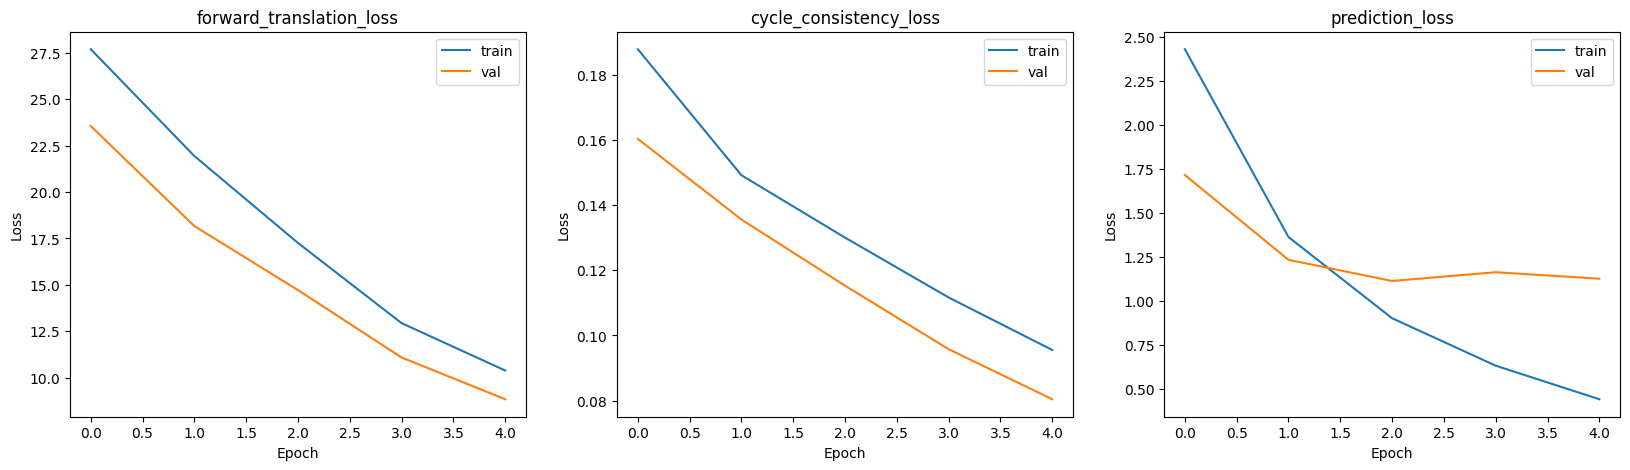

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_train_results(mctn_train_losses, mctn_val_losses):
    cols = ["forward_translation_loss", "cycle_consistency_loss", "prediction_loss"]
    train_mctn_losses_df = pd.DataFrame(mctn_train_losses, columns=cols)
    val_mctn_losses_df = pd.DataFrame(mctn_val_losses, columns=cols)

    _, ax = plt.subplots(1, 3, figsize=(20, 5))
    for i, loss in enumerate(cols):
        sns.lineplot(data=train_mctn_losses_df[loss], ax=ax[i], label="train")
        sns.lineplot(data=val_mctn_losses_df[loss], ax=ax[i], label="val")
        ax[i].set_title(loss)
        ax[i].set_xlabel("Epoch")
        ax[i].set_ylabel("Loss")

plot_train_results(mctn_train_losses, mctn_val_losses)
